# What is the relationship between ILIs and weather?

## Libraries and dependecies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

from datetime import datetime
from scipy.stats import linregress


## Functions

In [2]:
# function to resample temperature from dialy to weekly
def resample_temperature_by_week(daily_data_by_city) :
    resampled_temperature_by_week = daily_data_by_city['Avg'].resample('W').mean()
    
    daily_data_by_city['Precip'] = daily_data_by_city['Precip'].replace(['-'],'0')
    daily_data_by_city['Precip'] = daily_data_by_city['Precip'].astype('float')
    resampled_precipitation_by_week = daily_data_by_city['Precip'].resample('W').mean()
    
    weekly_average_temperature_df = resampled_temperature_by_week.to_frame()
    weekly_average_temperature_df.reset_index(inplace = True)
    weekly_average_temperature_df.rename(columns={'Avg': 'average_temperature', 'Date' : 'last_day_of_the_week'}, inplace = True)
    
    weekly_average_precipitation_df = resampled_precipitation_by_week.to_frame()
    weekly_average_precipitation_df.reset_index(inplace = True)
    weekly_average_precipitation_df.rename(columns={'Precip': 'average_precipitation'}, inplace = True)
    
    weekly_weather_df = weekly_average_temperature_df
    weekly_weather_df['average_precipitation'] = weekly_average_precipitation_df['average_precipitation']
    
    for index, day in weekly_weather_df.iterrows() :
        weekly_weather_df.loc[index, 'week'] = day['last_day_of_the_week'].isocalendar()[1]
        weekly_weather_df.loc[index, 'year'] = day['last_day_of_the_week'].isocalendar()[0]
    
    weekly_weather_df['week'] = weekly_weather_df['week'].astype(int)
    weekly_weather_df['year'] = weekly_weather_df['year'].astype(int)
    
    return weekly_weather_df


## Data cleanup

In [3]:
# Clean temperature and precipitation data set
CSV_DF = pd.read_csv("WEATHER_CSV/MASTER.csv")
CSV_LIST = CSV_DF['Name']

cities_weather_df = pd.DataFrame()

for city in CSV_LIST:
    resample_data =[]
    city_df = pd.read_csv(f"WEATHER_CSV/{city}.csv", parse_dates =["Date"], index_col ="Date")
    resample_data = resample_temperature_by_week(city_df)
    resample_data["State"]= city_df.iloc[0]['state']
    resample_data["City"]= city_df.iloc[0]['city_name']
    
    if len(cities_weather_df) < 1 :
        cities_weather_df = resample_data
    else:
        cities_weather_df = cities_weather_df.append(resample_data)

cities_weather_df['State'].replace(
    {
        'AZ':'Arizona', 'CA':'California', 'CO':'Colorado', 'GA':'Georgia', 'IL':'Illinois',
        'NY':'New York', 'PA':'Pennsylvania', 'TX':'Texas', 'WA':'Washington'
    }, inplace = True
)

cities_weather_df = cities_weather_df[
    ['year', 'week', 'State', 'City', 'average_temperature', 'average_precipitation', 'last_day_of_the_week']
]

cities_weather_df = cities_weather_df[
    (cities_weather_df['year'] != 2020) &
    (cities_weather_df['year'] != 2019) &
    (cities_weather_df['year'] != 2009) &
    ~((cities_weather_df['week'] < 40) & (cities_weather_df['year'] == 2010))
]

# Create clean CSV file for temperature data
cities_weather_df.to_csv('Data/Cities_Weather.csv', encoding = 'utf-8', index = False)
cities_weather_df

,year,week,State,City,average_temperature,average_precipitation,last_day_of_the_week
92,2010,40,Georgia,Atlanta,64.071429,0.000000,2010-10-10
93,2010,41,Georgia,Atlanta,66.500000,0.001429,2010-10-17
94,2010,42,Georgia,Atlanta,65.214286,0.010000,2010-10-24
95,2010,43,Georgia,Atlanta,65.428571,0.471429,2010-10-31
96,2010,44,Georgia,Atlanta,50.142857,0.117143,2010-11-07
...,...,...,...,...,...,...,...
517,2018,48,Washington,Seattle,47.357143,0.532857,2018-12-02
518,2018,49,Washington,Seattle,40.857143,0.084286,2018-12-09
519,2018,50,Washington,Seattle,47.357143,0.225714,2018-12-16
520,2018,51,Washington,Seattle,46.214286,0.364286,2018-12-23


In [4]:
# Clean ILI Cases data set

# Read the flu data and skip header row
ILI_df = pd.read_csv("FluViewPhase2Data/ILINet.csv", skiprows=1)

#Change any X values to zero
ILI_df_clean = ILI_df.replace('X',0)

#Convert result columns to numbers
ILI_df_clean['ILITOTAL'] = pd.to_numeric(ILI_df_clean['ILITOTAL'])
ILI_df_clean['NUM. OF PROVIDERS'] = pd.to_numeric(ILI_df_clean['NUM. OF PROVIDERS'])
ILI_df_clean['TOTAL PATIENTS'] = pd.to_numeric(ILI_df_clean['TOTAL PATIENTS'])

#Filter to desired states that we have weather data for
filtered_df = ILI_df_clean.loc[(ILI_df_clean['REGION']=='New York')|(ILI_df_clean['REGION']=='Illinois')|
                               (ILI_df_clean['REGION']=='Texas')|(ILI_df_clean['REGION']=='Arizona')|
                               (ILI_df_clean['REGION']=='Georgia')|(ILI_df_clean['REGION']=='Pennsylvania')|
                               (ILI_df_clean['REGION']=='California')|(ILI_df_clean['REGION']=='Washington')|
                               (ILI_df_clean['REGION']=='Colorado')]

#Re-name columns to match weather dataset; Give ILITOTAL more meaning
renamed_df = filtered_df.rename(columns = {'REGION': 'State', 'YEAR':'year', 'WEEK':'week',
                                           'ILITOTAL':'reported_ILI_cases_per_week'})

States_Reported_ILI_Cases = renamed_df[['year', 'week', 'State', 'reported_ILI_cases_per_week']]

States_Reported_ILI_Cases = States_Reported_ILI_Cases[
    (States_Reported_ILI_Cases['year'] != 2020) &
    (States_Reported_ILI_Cases['year'] != 2019)
]

# Create clean CSV file for ILI cases data 
States_Reported_ILI_Cases.to_csv('Data/States_Reported_ILI_Cases.csv', index = False)
States_Reported_ILI_Cases

,year,week,State,reported_ILI_cases_per_week
2,2010,40,Arizona,172
4,2010,40,California,632
5,2010,40,Colorado,134
10,2010,40,Georgia,647
13,2010,40,Illinois,505
...,...,...,...,...
22971,2018,52,Illinois,1339
22990,2018,52,New York,1757
22996,2018,52,Pennsylvania,1442
23001,2018,52,Texas,1317


## Data merge

In [5]:
# Merge temperature and ILI cases in one dataframe
weather_and_reported_ILI_cases_df = pd.merge(States_Reported_ILI_Cases, cities_weather_df, on = ['year', 'week', 'State'])

weather_and_reported_ILI_cases_df = weather_and_reported_ILI_cases_df[
    ['year', 'week', 'State', 'City', 'average_temperature', 'average_precipitation', 'reported_ILI_cases_per_week', 'last_day_of_the_week']
]

weather_and_reported_ILI_cases_df


,year,week,State,City,average_temperature,average_precipitation,reported_ILI_cases_per_week,last_day_of_the_week
0,2010,40,Arizona,Phoenix,78.642857,0.061429,172,2010-10-10
1,2010,40,California,Los Angeles,69.857143,0.067143,632,2010-10-10
2,2010,40,Colorado,Denver,57.071429,0.295714,134,2010-10-10
3,2010,40,Georgia,Atlanta,64.071429,0.000000,647,2010-10-10
4,2010,40,Illinois,Chicago,61.642857,0.000000,505,2010-10-10
...,...,...,...,...,...,...,...,...
3856,2018,52,Illinois,Chicago,34.571429,0.112857,1339,2018-12-30
3857,2018,52,New York,New York,40.928571,0.151429,1757,2018-12-30
3858,2018,52,Pennsylvania,Philadelphia,41.214286,0.241429,1442,2018-12-30
3859,2018,52,Texas,Houston,57.142857,0.285714,1317,2018-12-30


## Plots

In [6]:
cities = weather_and_reported_ILI_cases_df['City'].unique()

dataframe = []
for city in range(len(cities)):
    dataframe.append(weather_and_reported_ILI_cases_df[weather_and_reported_ILI_cases_df['City'] == cities[city]])

temp_values = []
ili_values = []
ldw_num_values = []

#Form empty lists to store regression values
slope_results = []
intercept_results = []
rvalue_results = []
regress_values = []
line_eq = []
r_squared = []

#Run for loop to get all regression values for each city
for variable in range(len(dataframe)):
    #Append x and y lists with temperature and ILI Total from individual city's dataframe
    temp_values.append(dataframe[variable]['average_temperature'])
    ili_values.append(dataframe[variable]['reported_ILI_cases_per_week'])
    ldw_num_values.append(dataframe[variable]['last_day_of_the_week'])
    
    #Perform the regression analysis on above variables and append each list for individual city
    [slope, intercept, rvalue, pvalue, stderr] = linregress(temp_values[variable], ili_values[variable])
    slope_results.append(slope)
    intercept_results.append(intercept)
    rvalue_results.append(rvalue)
    regress_values.append(temp_values[variable] * slope_results[variable] + intercept_results[variable])
    line_eq.append("y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)))
    r_squared.append("R^2 = " + str(round(rvalue**2,3)))

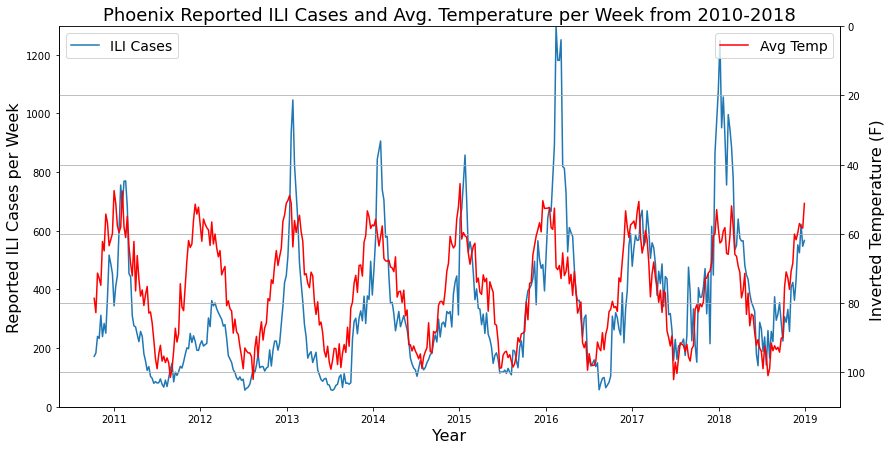

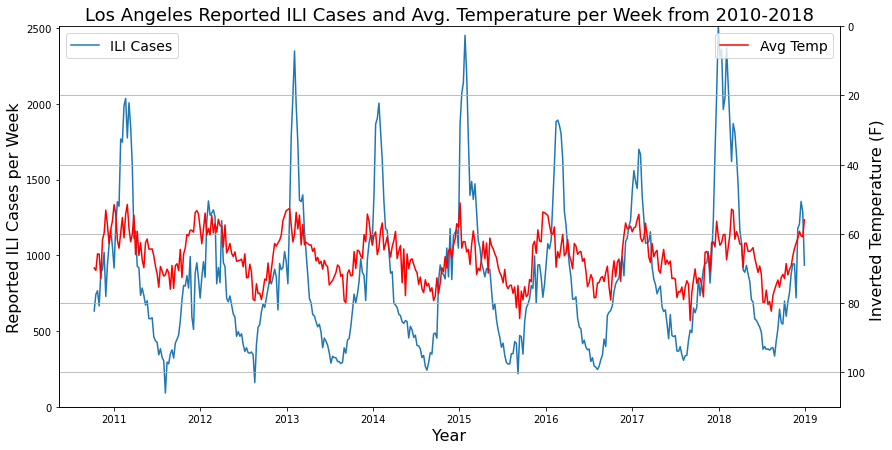

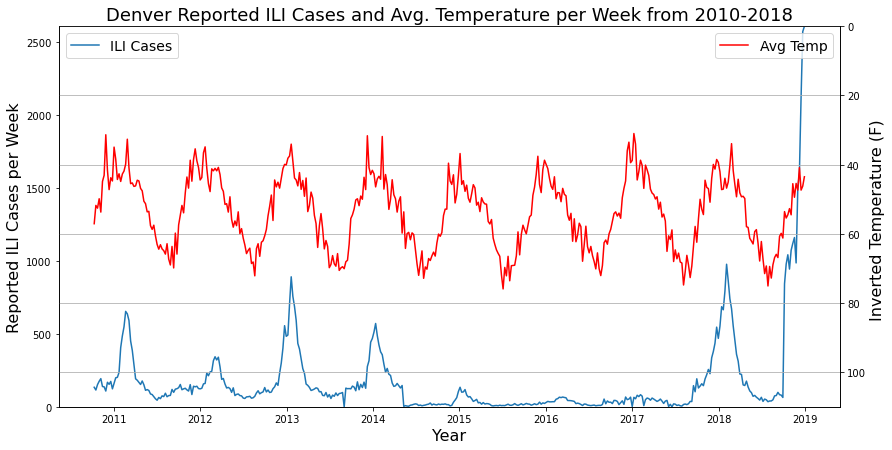

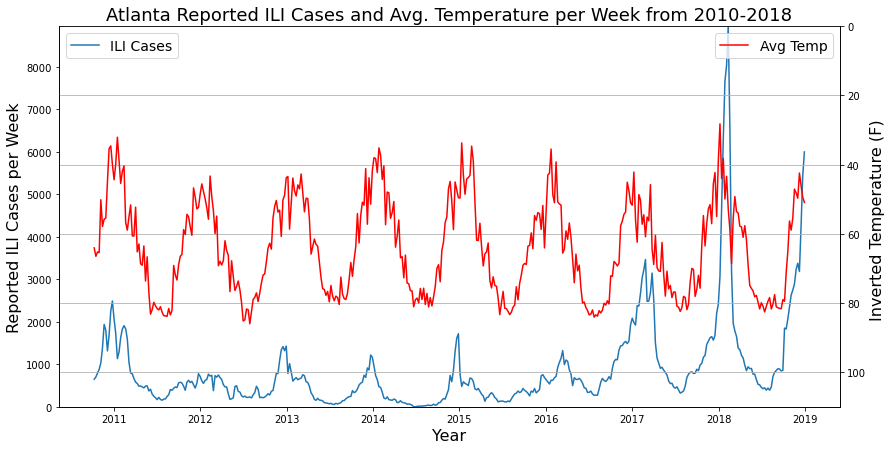

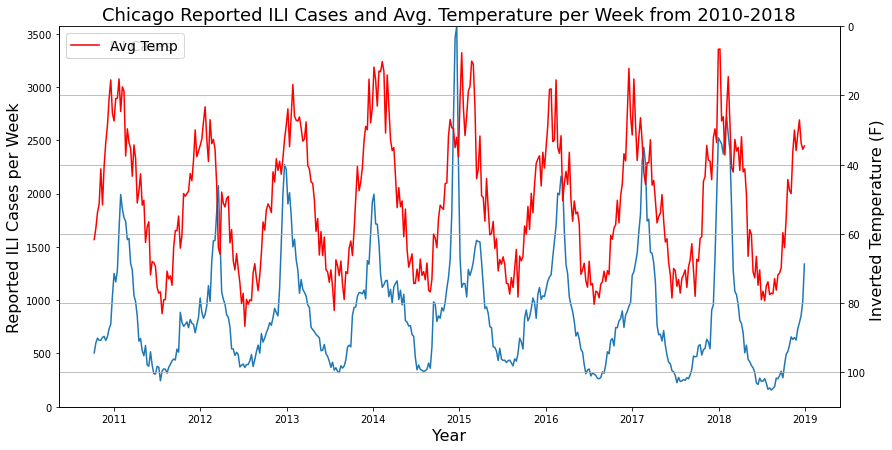

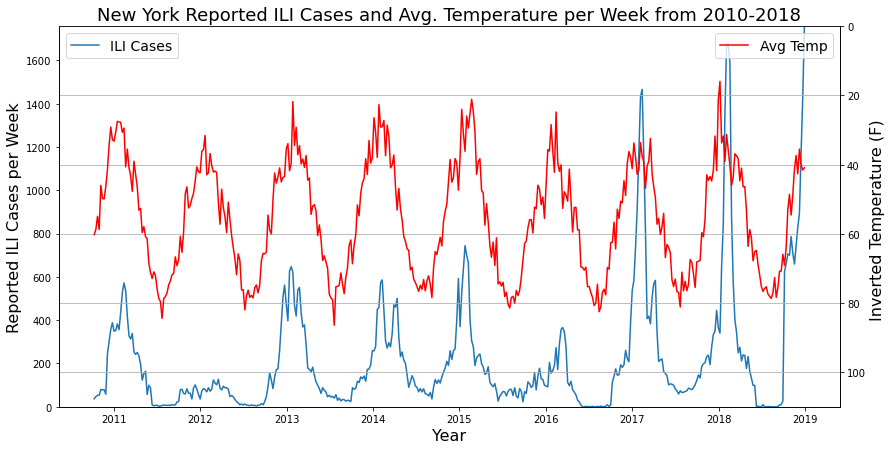

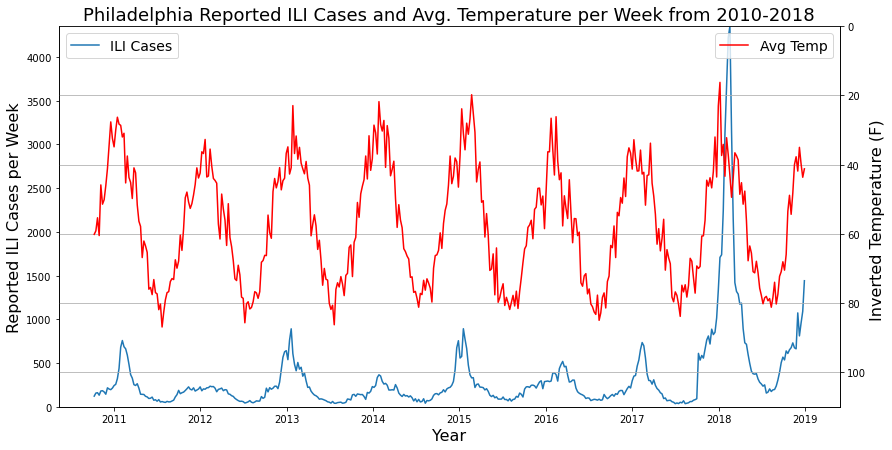

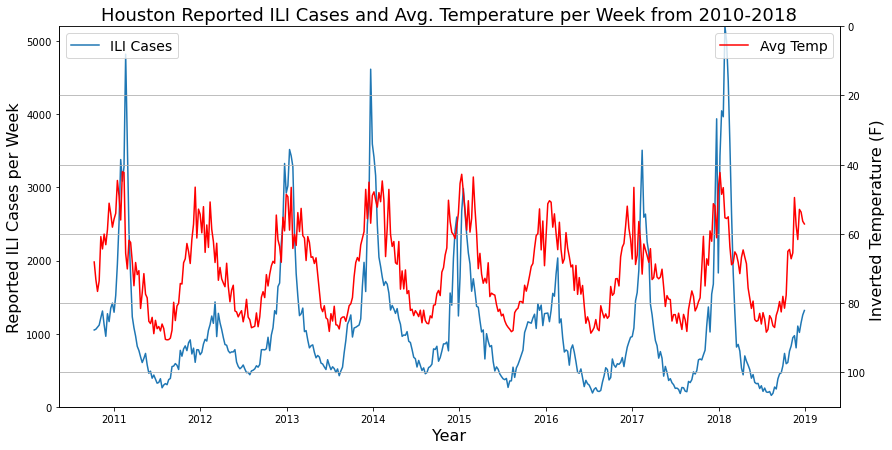

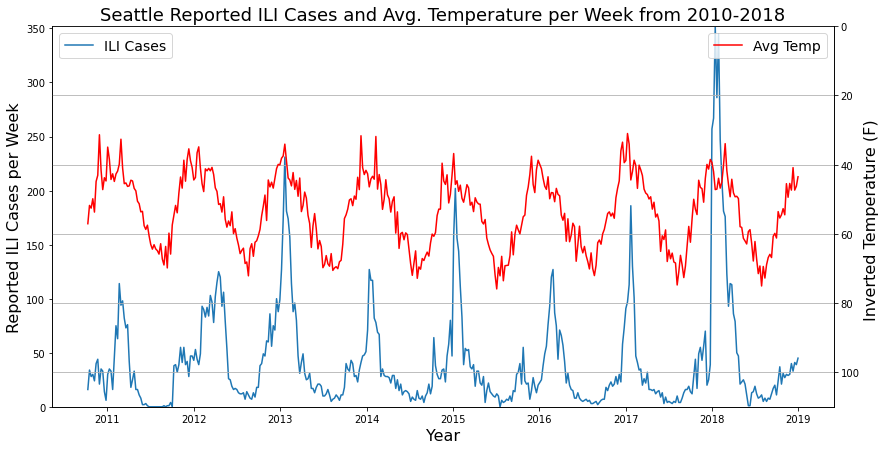

In [7]:
#Return scatterplot w/ best-fit line for each State and save to file
for city in range(len(cities)):
    #Form first plot using ILI cases by week
    fig, ax1 = plt.subplots()
    ax1.plot(ldw_num_values[city],ili_values[city], label='ILI Cases')
    plt.ylabel('Reported ILI Cases per Week', fontsize = 16)
    plt.xlabel('Year', fontsize = 16)
    ax1.legend(loc='upper left',fontsize = 14)
    plt.ylim((0,ili_values[city].max()))

    #Form second plot using same x-axis but secondary y-axis for average temperature
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.plot(ldw_num_values[city],temp_values[city], label='Avg Temp',color ='red')
    plt.ylim((0,110))
    plt.gca().invert_yaxis() #invert y-axis so trend is similar
    plt.ylabel('Inverted Temperature (F) ', fontsize = 16)
    ax2.legend(fontsize = 14)

    #Show dual plot w/ grid and save plot to picture file
    plt.grid(True)
    plt.title(f'{cities[city]} Reported ILI Cases and Avg. Temperature per Week from 2010-2018', fontsize = 18)
    fig.set_size_inches(14, 7, forward=True)
    filepath = (f'Plots/Temperature/Line_Plots/{cities[city]}_Reported_ILI_Cases_and_Avg_Temperature_per_Week_from 2010-2018.png')
    plt.savefig(filepath)
plt.show()

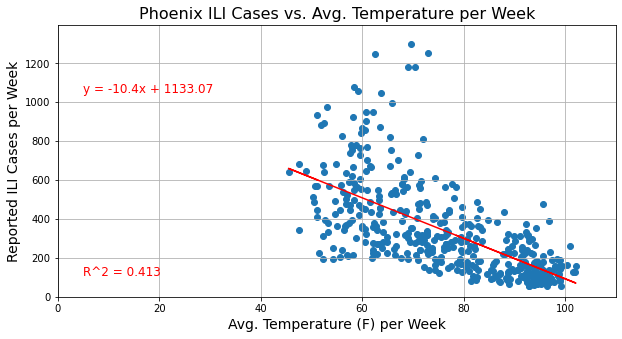

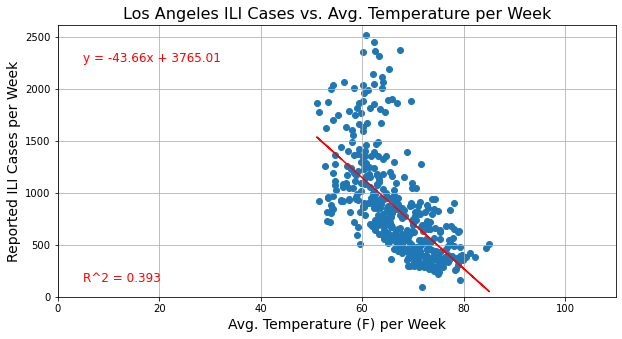

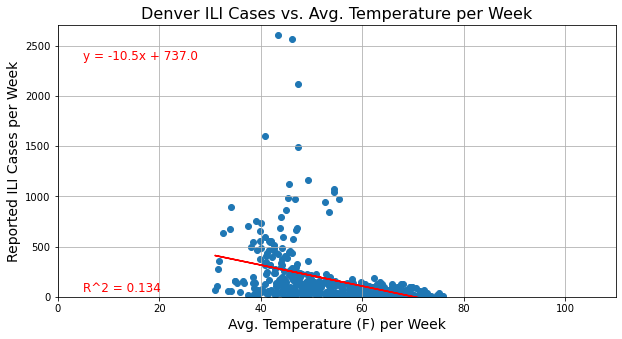

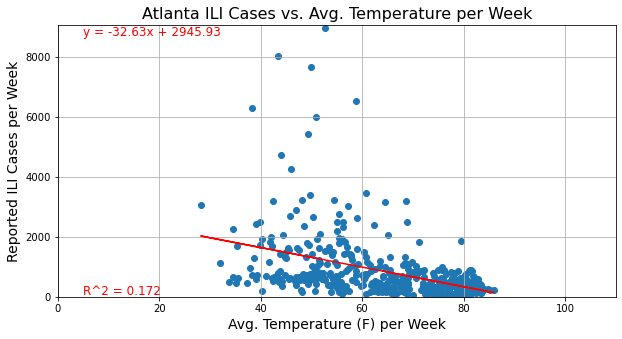

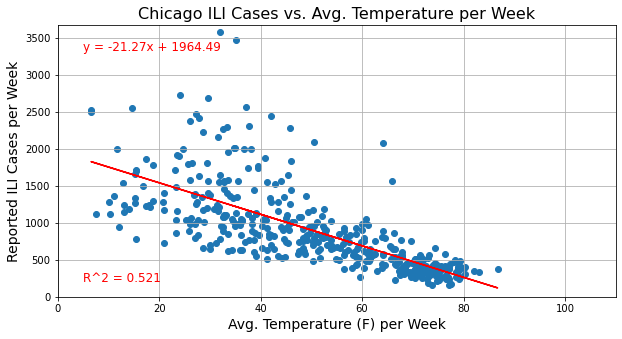

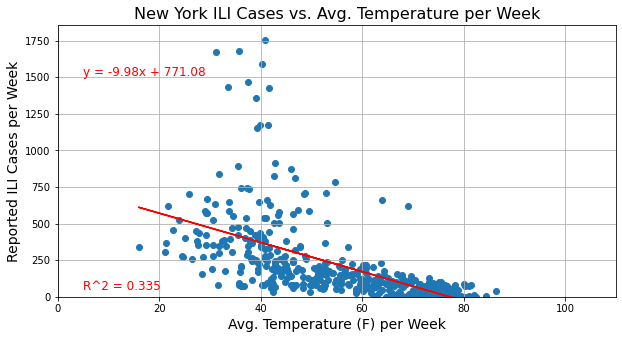

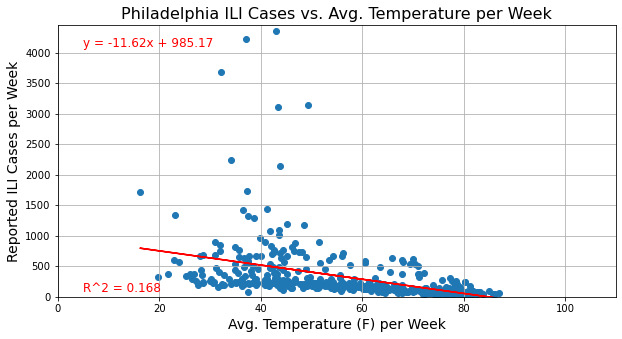

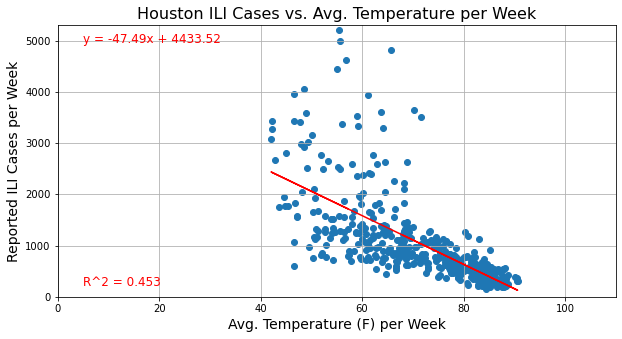

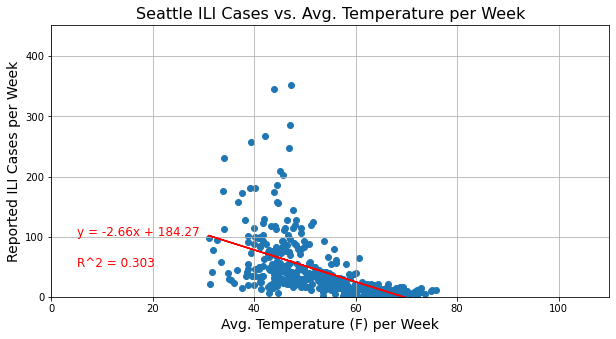

In [8]:
#Return scatterplot w/ best-fit line for each State and save to file
for city in range(len(cities)):
    plt.figure(figsize=(10,5))
    plt.scatter(temp_values[city],ili_values[city])
    plt.grid(True)
    plt.plot(temp_values[city],regress_values[city],"r-")
    plt.annotate(line_eq[city],(5,ili_values[city].max()-250),fontsize=12,color='r')
    plt.annotate(r_squared[city],(5,ili_values[city].min()+50),fontsize=12, color='r')
    plt.ylabel('Reported ILI Cases per Week', fontsize = 14)
    plt.ylim((0,ili_values[city].max()+100))
    plt.xlabel('Avg. Temperature (F) per Week', fontsize = 14)
    plt.xlim((0,110))
    plt.title(f'{cities[city]} ILI Cases vs. Avg. Temperature per Week', fontsize=16)
    filepath = (f'Plots/Temperature/Scatter_Plots/{cities[city]}_ILI Total_Cases_vs_Avg_Temperature.png')
    plt.savefig(filepath)
plt.show()

In [9]:
#Pass each cities dataframe through loop to return regression results
#Form empty lists for x and y values for scatter plot/line plot
temp_values = []
ili_values = []
ldw_num_values = []

#Form empty lists to store regression values
slope_results = []
intercept_results = []
rvalue_results = []
regress_values = []
line_eq = []
r_squared = []

#Run for loop to get all regression values for each city
for variable in range(len(dataframe)):
    #Append x and y lists with temperature and ILI Total from individual city's dataframe
    temp_values.append(dataframe[variable]['average_precipitation'])
    ili_values.append(dataframe[variable]['reported_ILI_cases_per_week'])
    ldw_num_values.append(dataframe[variable]['last_day_of_the_week'])
    
    #Perform the regression analysis on above variables and append each list for individual city
    [slope, intercept, rvalue, pvalue, stderr] = linregress(temp_values[variable], ili_values[variable])
    slope_results.append(slope)
    intercept_results.append(intercept)
    rvalue_results.append(rvalue)
    regress_values.append(temp_values[variable] * slope_results[variable] + intercept_results[variable])
    line_eq.append("y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)))
    r_squared.append("R^2 = " + str(round(rvalue**2,3)))

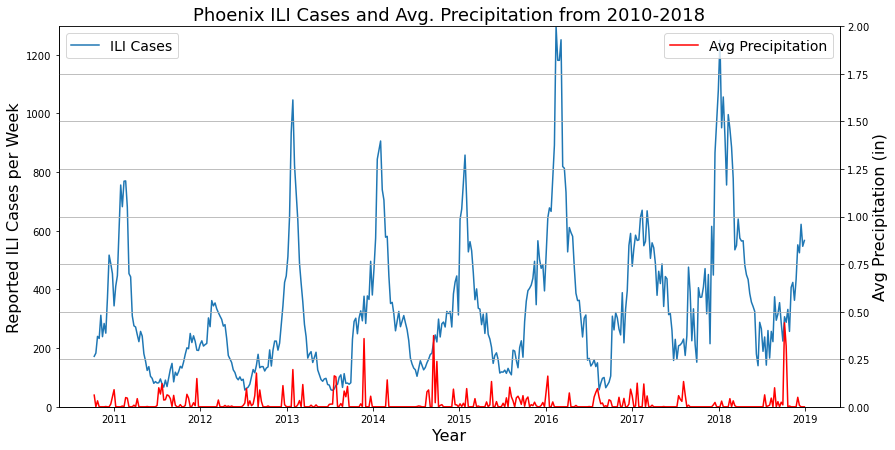

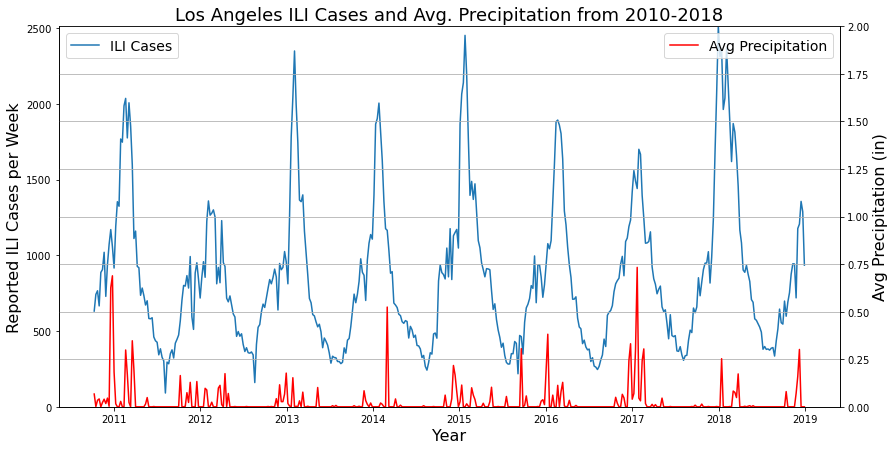

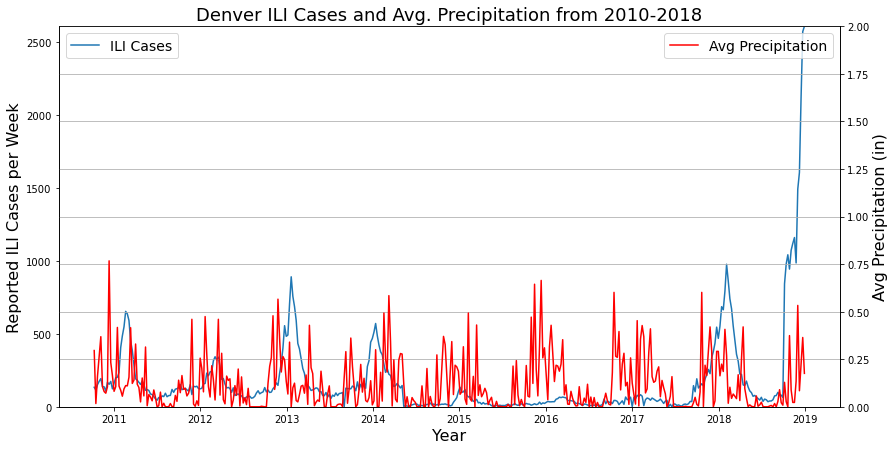

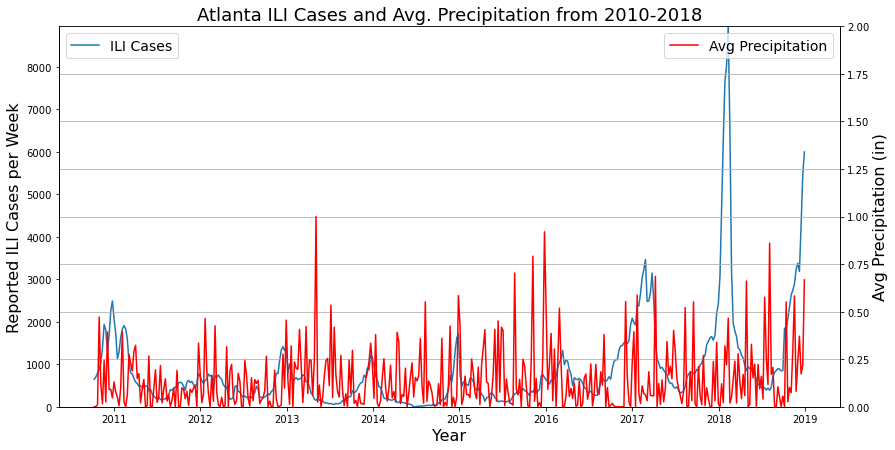

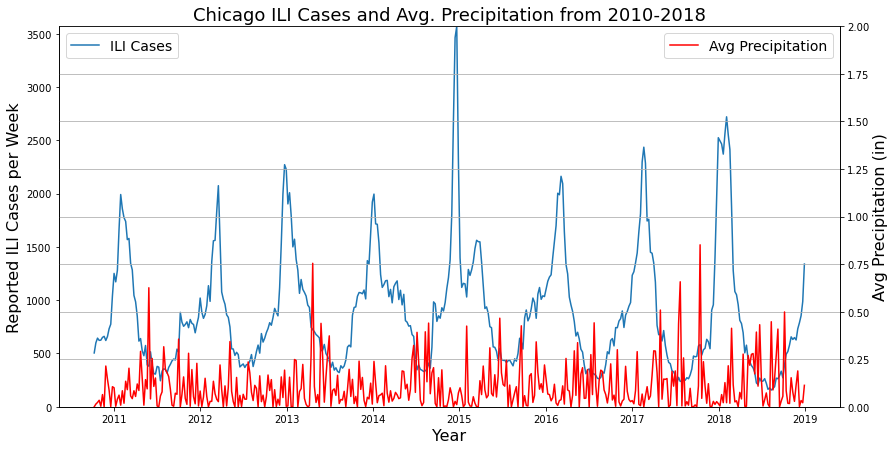

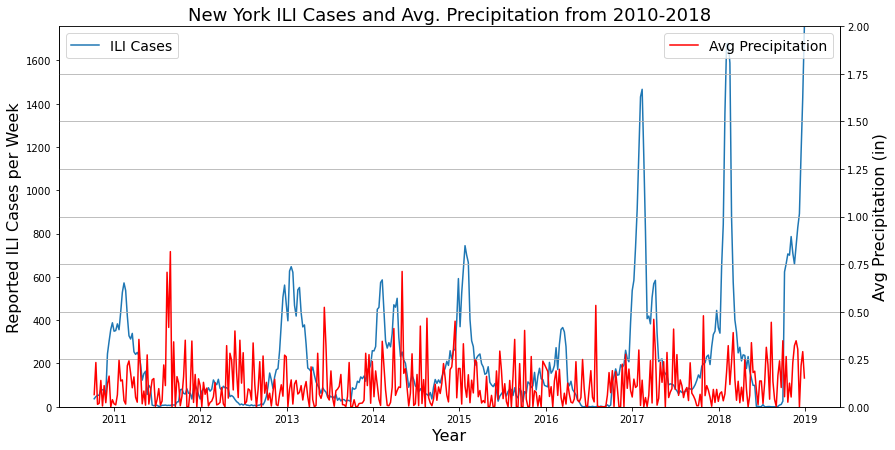

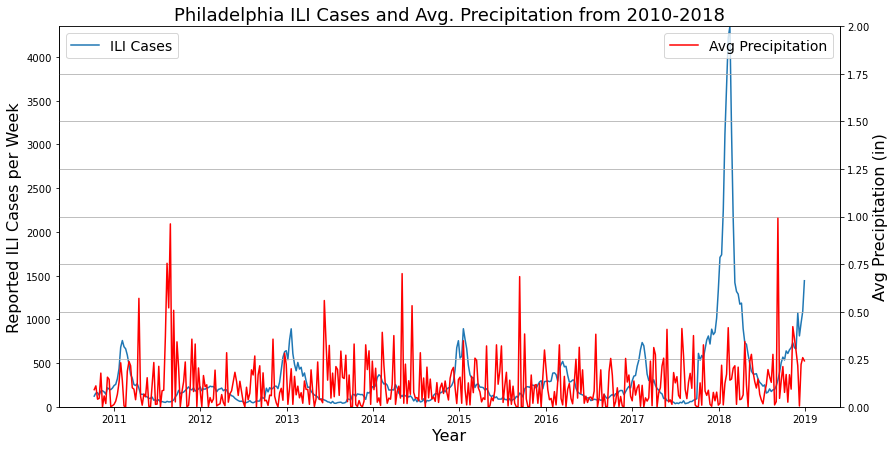

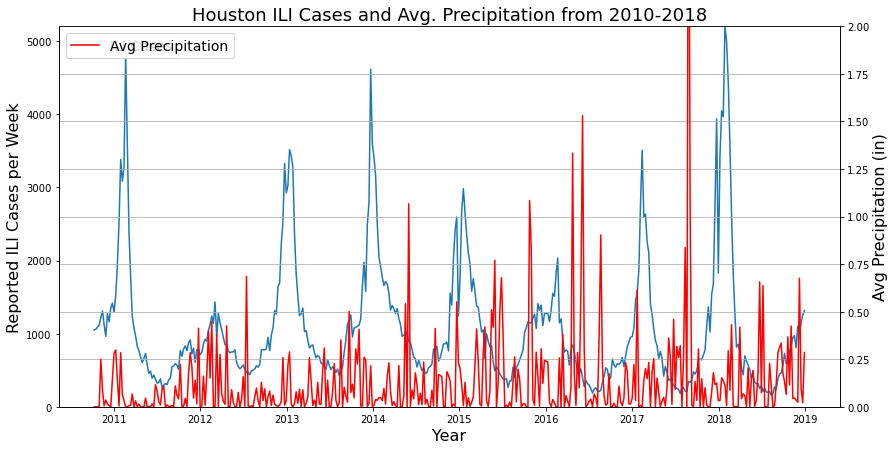

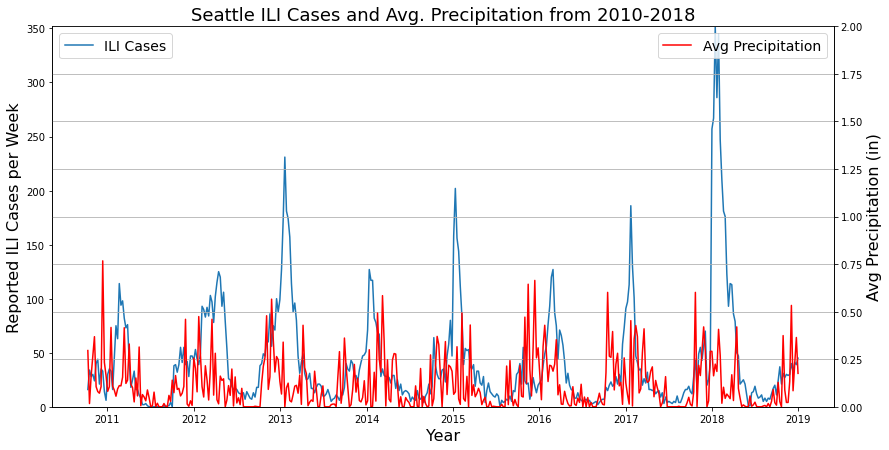

In [10]:
#Line plots per city for all years
for city in range(len(cities)):
    #Form first plot using ILI cases by week
    fig, ax1 = plt.subplots()
    ax1.plot(ldw_num_values[city],ili_values[city], label='ILI Cases')
    plt.ylabel('Reported ILI Cases per Week', fontsize = 16)
    plt.xlabel('Year', fontsize = 16)
    ax1.legend(loc='upper left',fontsize = 14)
    plt.ylim((0,ili_values[city].max()))

    #Form second plot using same x-axis but secondary y-axis for average precipitation
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.plot(ldw_num_values[city],temp_values[city], label='Avg Precipitation',color ='red')
    plt.ylim((0,2))
    plt.ylabel('Avg Precipitation (in)', fontsize = 16)
    ax2.legend(fontsize = 14)

    #Show dual plot w/ grid and save plot to picture file
    plt.grid(True)
    plt.title(f'{cities[city]} ILI Cases and Avg. Precipitation from 2010-2018', fontsize = 18)
    fig.set_size_inches(14, 7, forward=True)
    filepath = (f'Plots/Precipitation/Line_Plots/{cities[city]}_ILI_Cases_and_Avg_Precipitation_from_2010-2018.png')
    plt.savefig(filepath)
plt.show()

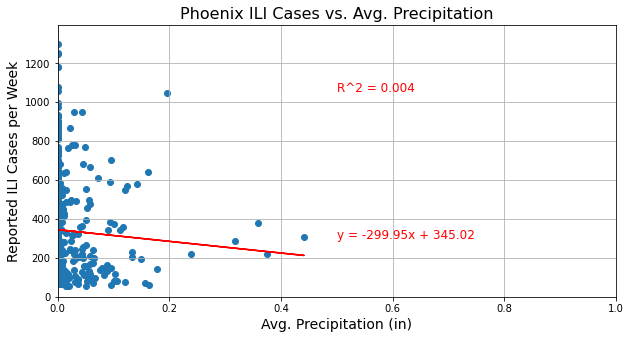

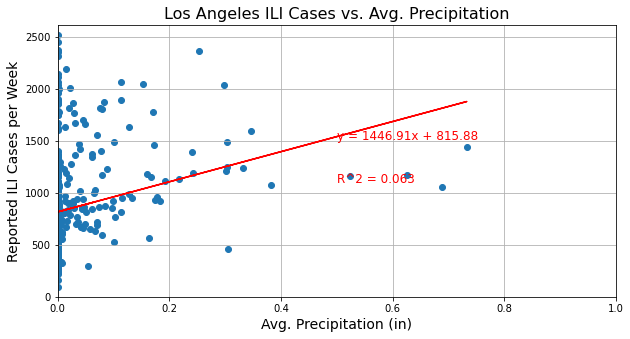

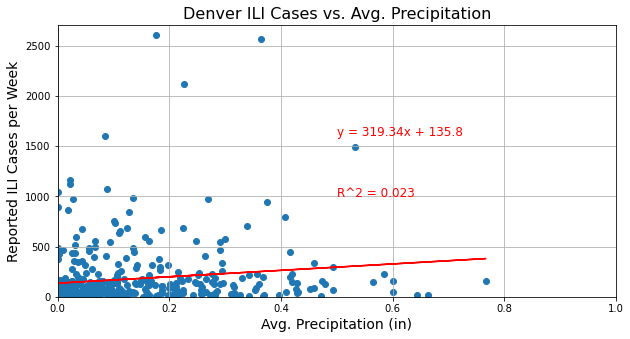

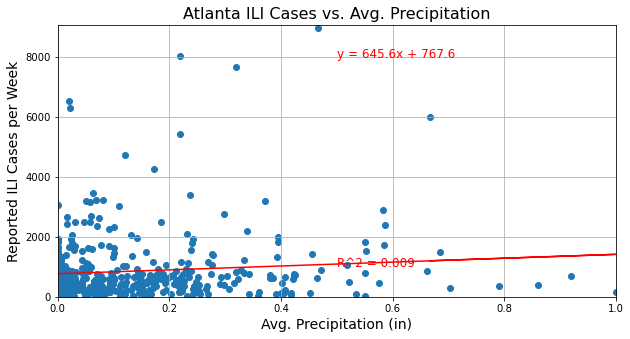

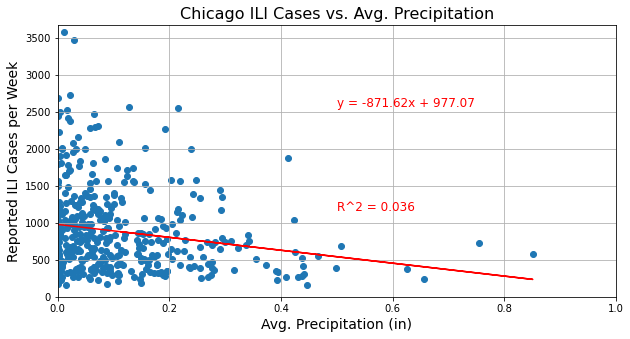

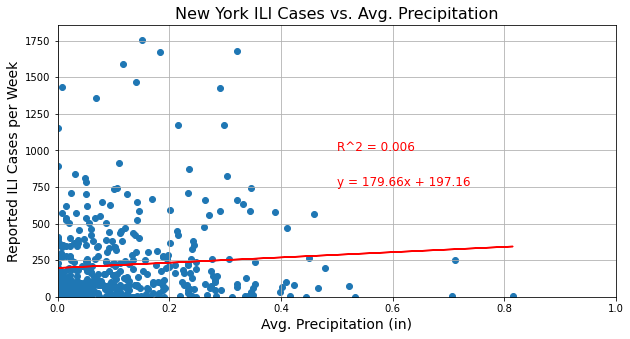

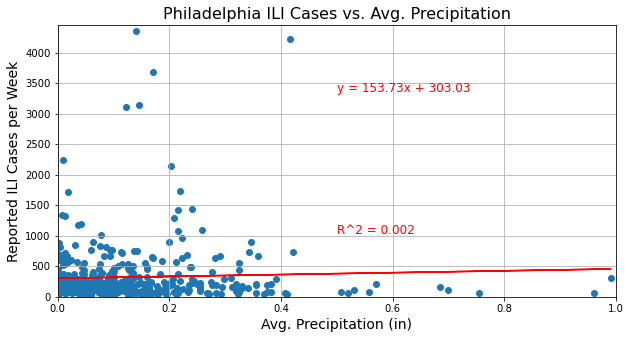

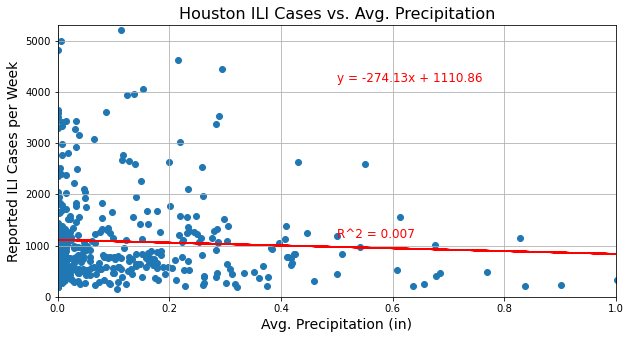

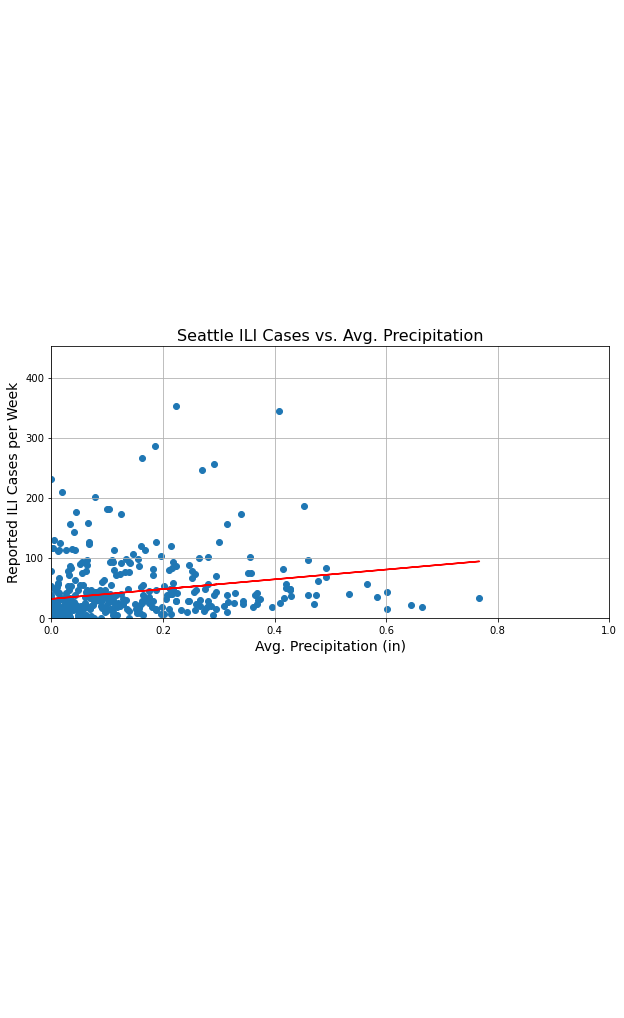

In [11]:
#Return scatterplot w/ best-fit line for each State and save to file
for city in range(len(cities)):
    plt.figure(figsize=(10,5))
    plt.scatter(temp_values[city],ili_values[city])
    plt.grid(True)
    plt.plot(temp_values[city],regress_values[city],"r-")
    plt.annotate(line_eq[city],(.5,ili_values[city].max()-1000),fontsize=12,color='r')
    plt.annotate(r_squared[city],(.5,ili_values[city].min()+1000),fontsize=12, color='r')
    plt.ylabel('Reported ILI Cases per Week', fontsize = 14)
    plt.ylim((0,ili_values[city].max()+100))
    plt.xlabel('Avg. Precipitation (in)', fontsize = 14)
    plt.xlim((0,1))
    plt.title(f'{cities[city]} ILI Cases vs. Avg. Precipitation', fontsize=16)
    filepath = (f'Plots/Precipitation/Scatter_Plots/{cities[city]}_ILI_Cases_vs_Avg_Precipitation.png')
    plt.savefig(filepath)
plt.show()